To ensure all sections of this notebook function correctly, please execute:
1. Setup notebook
2. Setup data

I've tried to keep functions fairly generalised so they can be used for different use cases!

# Setup notebook

Boilerplate code to correctly setup the settings for the notebook.

In [195]:
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    print(root)
    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/pemb6649/pi0-analysis/analysis/summer-placement

/home/pemb6649//pi0-analysis/analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/pemb6649//pi0-analysis/analysis
env: PYTHONPATH=/home/pemb6649//pi0-analysis/analysis


In [196]:
from rich import print

# Note these are examples of the mose useful/common libraries to rely on
from python.analysis import (
    Master, # Core library for Ntuple file manipulation
    BeamParticleSelection, # Defined selections for the beam particle.
    PFOSelection, # Defined selections for (Particle Flow Objects) PFOs
    Plots, # Plotting functions
    vector, # doing vector operations using Awkward.
    Tags, # Creating event tags
    cross_section, # Helper functions specifically for the cross section analysis code
    EventSelection, # Helper functions for event selection,
    SelectionTools # Helper functions for event selection
)# Fo


from apps.cex_analysis_input import BeamPionSelection
from python.analysis import Utils

cross_section.PlotStyler.SetPlotStyle(dpi = 100, dark = True) # set the plot style to use (aesthetics)

In [197]:
# required libraries for the ML approach

import awkward as ak # library for manipulating vectors faster than numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

# models

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# other

import pickle
from datetime import datetime
import dill

# custom functions

from utils import *


# Setup data
Setup and extract the observables from the MC.

In [138]:
# define mc data
mc = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_sce_datadriven_ntuple_v09_81_00d01_set0.root", nTuple_type = Master.Ntuple_Type.PDSP, target_momentum = 2)
print(f"Original events: {len(mc.eventNum)}")

Original events: 131266

In [139]:
# load the beam selection mask
beam_mask = Master.LoadObject("/home/pemb6649/pi0-analysis/analysis/work/analysis_demo/masks_mc/beam_selection_masks.dill")
mask = beam_mask[mc.filename]
combined_mask = SelectionTools.CombineMasks(mask)
print(f"Beam selected events: {sum(combined_mask)}")

Beam selected events: 31476

In [ ]:
# start by using 10,000 events with the default observables from the extract_observables function
data = extract_observables(mc, size=10000, beam_selection_mask=combined_mask, verbose=True)
print(data[0])

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Considered 10000 original events.
Rejected 7581 events through beam selection.
Skipped 0 tracks due to errors.
Number of tracks: 9428


{
    'track_dEdX_mean': 2.558226866381509,
    'track_dEdX_median': 1.9872541427612305,
    'track_dQdX_mean': 71.89189985820225,
    'track_dQdX_median': 60.625261306762695,
    'residual_range_mean': 4.318397667791162,
    'residual_range_median': 4.346254587173462,
    'track_chi2/ndof_proton': 189.4326764168931,
    'track_chi2/ndof_pion': 21.373347526616104,
    'track_chi2/ndof_muon': 14.285213670655741,
    'track_length': 7.555305181307957,
    'track_score': 0.08923625445106265,
    'track_vertex_michel': 6.598455097293424,
    'track_vertex_nhits': 20,
    'track_start_pos_x': -70.82675170898438,
    'track_start_pos_y': 401.7236022949219,
    'track_start_pos_z': 94.09564208984375,
    'track_end_pos_x': -75.680908203125,
    'track_end_pos_y': 399.13055419921875,
    'track_end_pos_z': 99.2721176147461,
    'particle': '$\\gamma$'
}

# ML workflow
Preliminary showcase of a random forest classifer.

## Manual

In [167]:
df = pd.DataFrame(data)
df.head()

track_dEdX_mean  track_dEdX_median  track_dQdX_mean  track_dQdX_median  \
0         2.558227           1.987254        71.891900          60.625261   
1         2.185762           2.032390        65.696295          61.969856   
2         2.697233           1.803803        70.462522          55.478149   
3        46.238247           6.665603       246.978881         157.095474   
4         0.957016           0.802299        27.266159          22.506063   

   residual_range_mean  residual_range_median  track_chi2/ndof_proton  \
0             4.318398               4.346255              189.432676   
1             2.672577               2.669007              215.380424   
2            47.342638              46.573074              166.324808   
3            13.027541              13.389076                1.984713   
4             2.434822               1.759761              285.341374   

   track_chi2/ndof_pion  track_chi2/ndof_muon  track_length  track_score  \
0             21.373348             14.285214      7.555305     0.089236   
1             24.721273             16.334994      7.812130     0.494838   
2             17.563040             14.788307     94.991625     0.875237   
3             35.581015             36.443756     23.881886     0.948290   
4             44.145326             30.075351      8.760562     0.002080   

   track_vertex_michel  track_vertex_nhits  track_start_pos_x  \
0             6.598455                  20         -70.826752   
1             5.771489                  44         -46.822456   
2             4.309568                   9         -44.871201   
3             0.000004                   2         -43.548687   
4             5.272155                  13         -95.880539   

   track_start_pos_y  track_start_pos_z  track_end_pos_x  track_end_pos_y  \
0         401.723602          94.095642       -75.680908       399.130554   
1         410.084839          70.002876       -49.824867       404.115784   
2         395.932922         140.981216      -104.971466       361.389008   
3         394.825745         140.071350       -50.745937       386.267365   
4         365.782501         208.046509       -93.991821       357.551147   

   track_end_pos_z         particle  
0        99.272118         $\gamma$  
1        74.050751  $\pi^{\pm}$:2nd  
2       205.434784  $\pi^{\pm}$:2nd  
3       161.125290              $p$  
4       210.375671         $\gamma$

In [168]:
df = clean_df(df, verbose=True)  # remove rows with missing values
x_train, x_test, y_train, y_test = split_data(df, verbose=True)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.


In [169]:
model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test).tolist()
y_test = y_test.tolist()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [170]:
pred_df = pd.DataFrame({
    "predicted": y_pred,
    "true": y_test
})
pred_df.head(10)

predicted             true
0          $p$              $p$
1     $\gamma$         $\gamma$
2          $p$  $\pi^{\pm}$:2nd
3          $p$              $p$
4     $\gamma$         $\gamma$
5          $p$              $p$
6  $\mu^{\pm}$      $\mu^{\pm}$
7          $p$              $p$
8  $\pi^{\pm}$      $\pi^{\pm}$
9     $\gamma$  $\pi^{\pm}$:2nd

In [171]:
pions = ["$\pi^{\pm}$"]

print(f"Charged pion purity: {purity(y_pred, y_test, pions, pions):.3f}")
print(f"Charged pion efficiency: {efficiency(y_pred, y_test, pions, pions):.3f}")

Charged pion purity: 0.625

Charged pion efficiency: 0.728

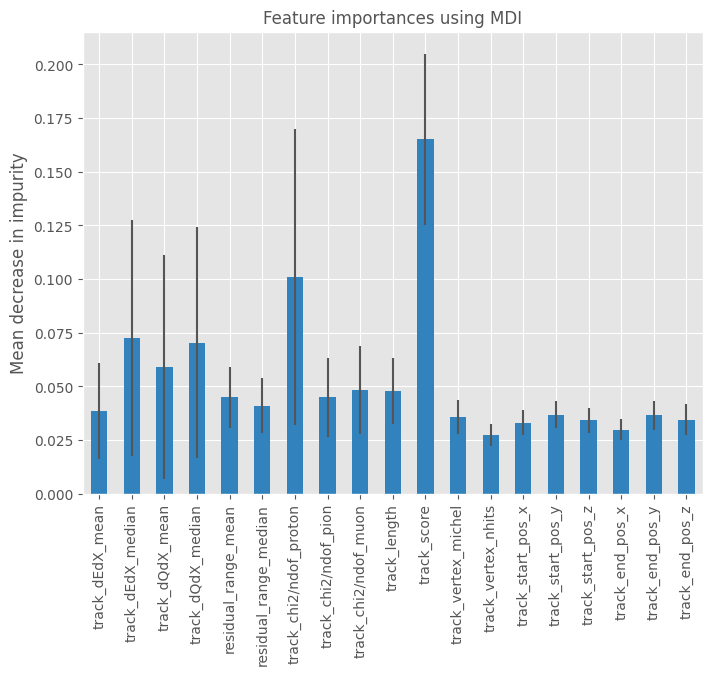

In [172]:
# plots the mean decrease in impurity (MDI) for each feature - see documentation

plot_feature_importances(model, x_train)

## Master function demo (automated workflow)

In [ ]:
# if not run already:
# data = extract_observables(mc, size=10000, beam_selection_mask=combined_mask, verbose=True)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.731
pi± purity: 0.625
pi± efficiency: 0.728
Purity x Efficiency: 0.455


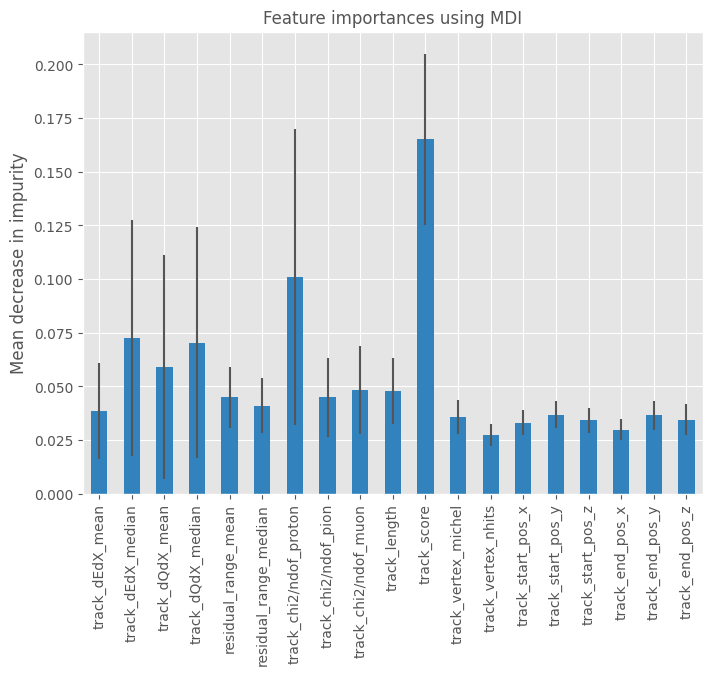

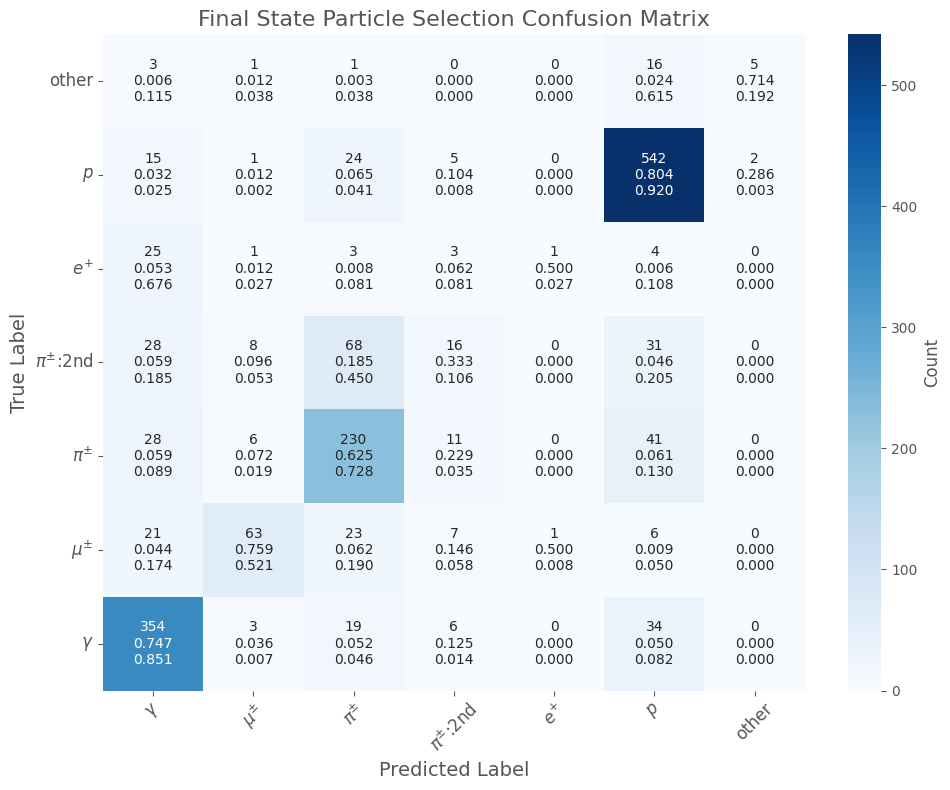

In [173]:
# this function automates the full ML pipeline

fitted_model = master_pion_selection(data=data, verbose=True, plot_importances=True, plot_cm=True)

# or let the master_pion_selection extract the data for you:
# fitted_model, pion_purity, pion_efficiency = master_pion_selection(ntuple=mc, size=10000, verbose=True, plot_importances=True, plot_cm=True)

# Testing different models
Investigating initial performance with a single decision tree, random forest, XGBoost, multi-layer perceptron classifer (netural network).

## Decision Tree

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.694
pi± purity: 0.510
pi± efficiency: 0.763
Purity x Efficiency: 0.389


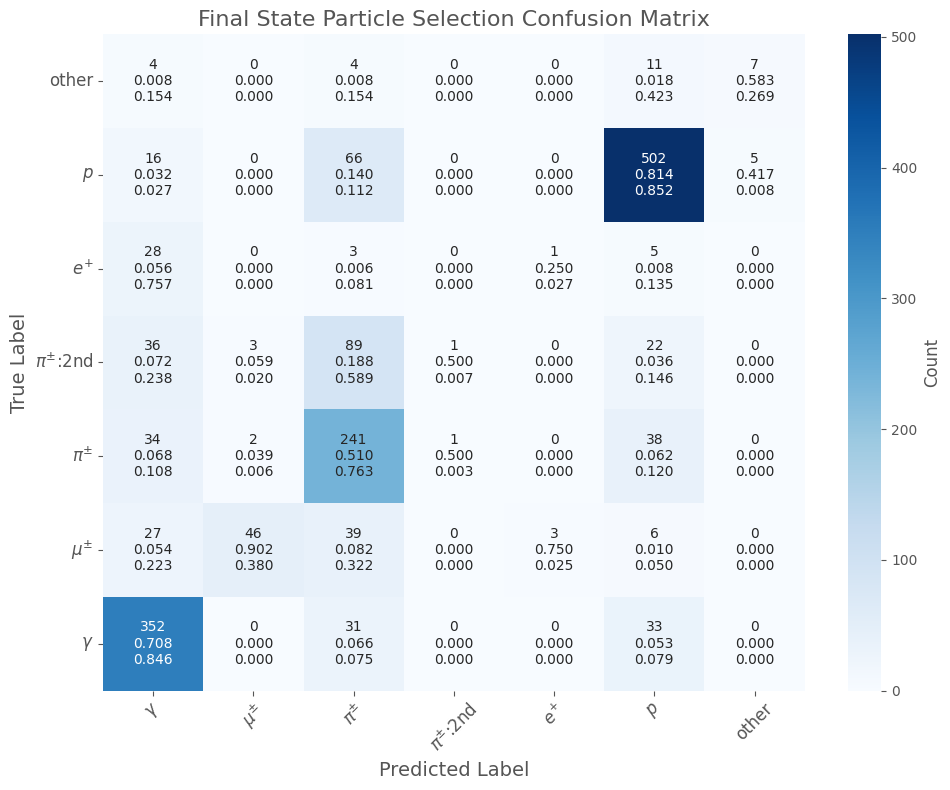

In [175]:
DT = DecisionTreeClassifier(max_depth=6, random_state=42)
DT = master_pion_selection(data=data, model=DT, verbose=True, plot_cm=True)

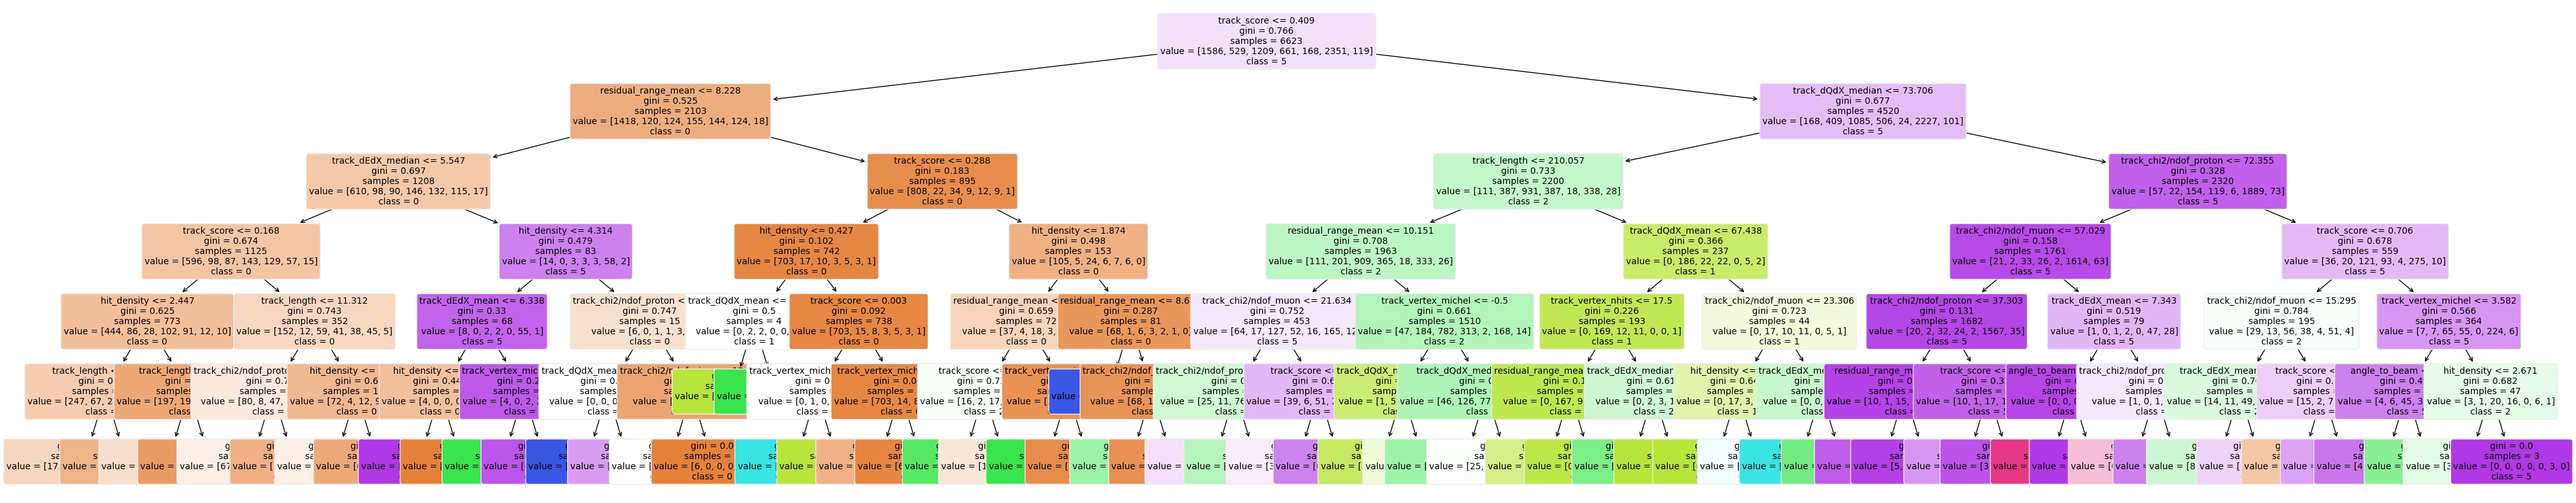

In [57]:
features = [k for k in data[0].keys() if k != "particle"]
class_names = [str(cls) for cls in DT.classes_]

output_dir = "/home/pemb6649/pi0-analysis/analysis/summer-placement/tree-visualisation"
os.makedirs(output_dir, exist_ok=True)

fig = plt.figure(figsize=(50, 10))
_ = tree.plot_tree(
    DT,
    feature_names=features,
    class_names=class_names,
    filled=True,
    fontsize=10,
    rounded=True
)
fig.savefig(os.path.join(output_dir, "decision_tree.png"))

## Random Forest

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.731
pi± purity: 0.625
pi± efficiency: 0.728
Purity x Efficiency: 0.455


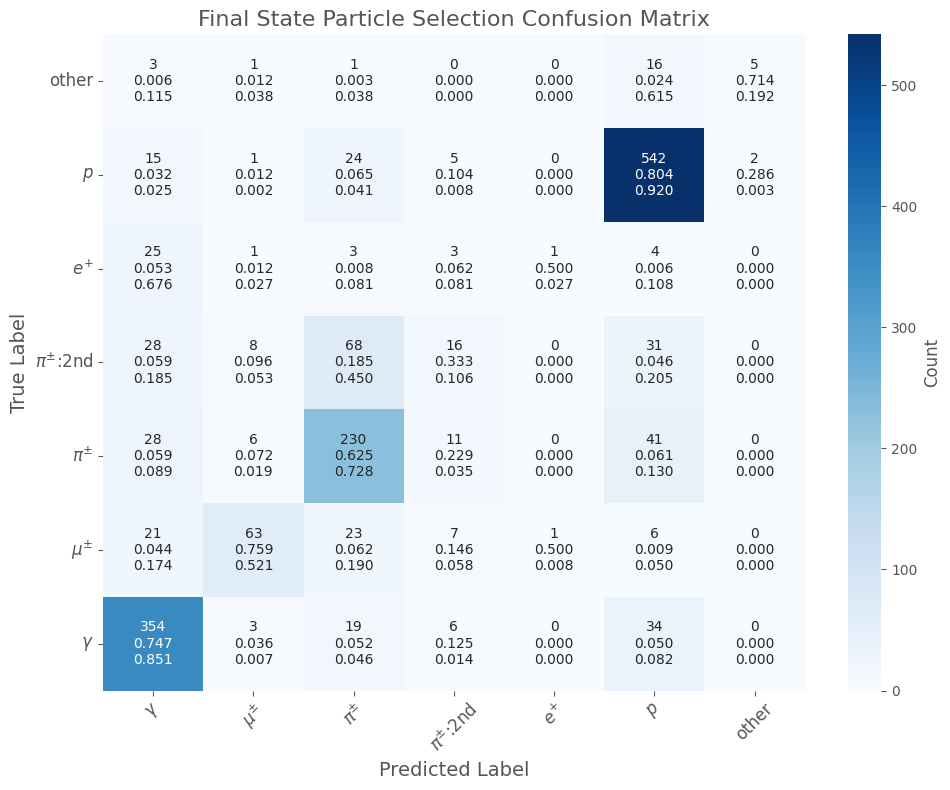

In [177]:
RF = RandomForestClassifier(n_estimators=100, random_state=42, criterion="gini");
RF = master_pion_selection(data=data, model=RF, verbose=True, plot_cm=True)

## XGBoost

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
[16:57:38] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.729
pi± purity: 0.607
pi± efficiency: 0.737
Purity x Efficiency: 0.447


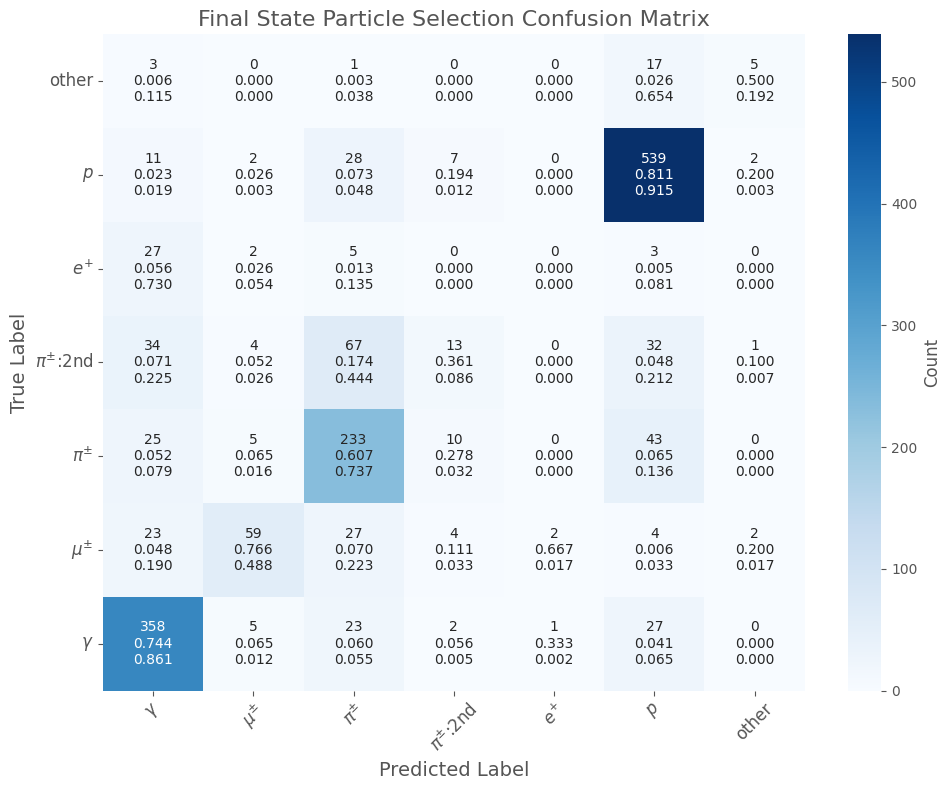

In [178]:
xgb = XGBClassifier(n_estimators=32, max_depth=5, learning_rate=0.15, random_state=42, scale_pos_weight=16)
xgb = master_pion_selection(data=data, model=xgb, verbose=True, plot_cm=True)

## MLP Classifier

In [181]:
mlp = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(32, 32))
mlp = master_pion_selection(data=data, model=mlp, verbose=True)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.505
pi± purity: 0.335
pi± efficiency: 0.778
Purity x Efficiency: 0.261


# Binary classification
Let's see how the performance is when we only have two classes: pion (1) and not pion (0).

Removed 1149 rows with missing entries. 


/home/pemb6649/pi0-analysis/analysis/summer-placement/utils.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = "0"
/home/pemb6649/pi0-analysis/analysis/summer-placement/utils.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = "1"


Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.868
pi± purity: 0.719
pi± efficiency: 0.503
Purity x Efficiency: 0.362


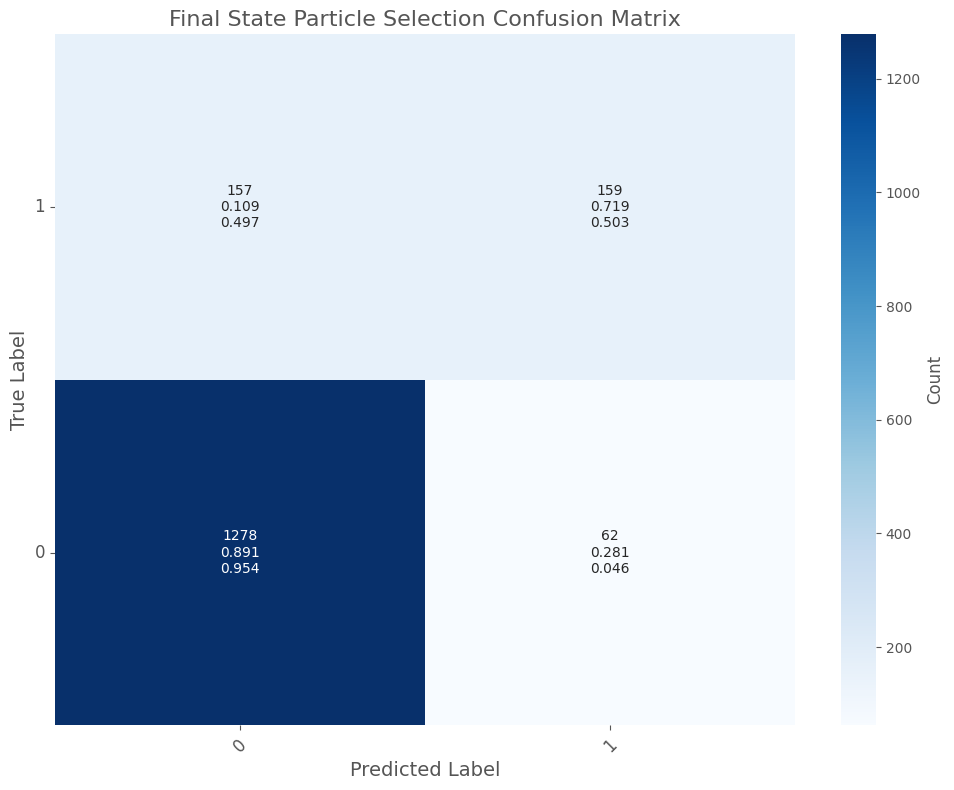

In [183]:
# we now specify binary_classification = True, i.e. the only classes are now pion (1) and not pion (0)
RF = RandomForestClassifier(n_estimators=100, random_state=42);
RF = master_pion_selection(data=data, model=RF, verbose=True, plot_cm=True, binary_classification=True, consider_dropped_rows=False)

# Hyperparameter tuning
Iteratively testing the performance of different hyperparameters.

In [ ]:
xgb_hyper_param_tuning = {
    "max_depth": [1, 3, 5, 10],
    "n_estimators": [1, 2, 4, 8, 16, 32],
    "learning_rate": [0.05, 0.1, 0.2, 0.5, 1]
}

hp_tuning_results = tune_hp(xgb_hyper_param_tuning, data, "xgb", plot=True, save=True, verbose=True, binary_classification=False, consider_dropped_rows=False);

TUNING RANDOM FOREST HYPERPARAMETERS
--------------------------------
Testing max_depth = 2...
Purity: 0.460, Efficiency: 0.717
--------------------------------
Testing max_depth = 4...
Purity: 0.515, Efficiency: 0.719
--------------------------------
Testing max_depth = 6...
Purity: 0.565, Efficiency: 0.673
--------------------------------
Testing max_depth = 8...
Purity: 0.572, Efficiency: 0.703
--------------------------------
Testing max_depth = 10...
Purity: 0.570, Efficiency: 0.708
--------------------------------
Testing max_depth = 12...
Purity: 0.584, Efficiency: 0.716
--------------------------------
Testing max_depth = 14...
Purity: 0.579, Efficiency: 0.708
--------------------------------
Testing max_depth = 16...
Purity: 0.579, Efficiency: 0.705
--------------------------------
Testing max_depth = 18...
Purity: 0.581, Efficiency: 0.709


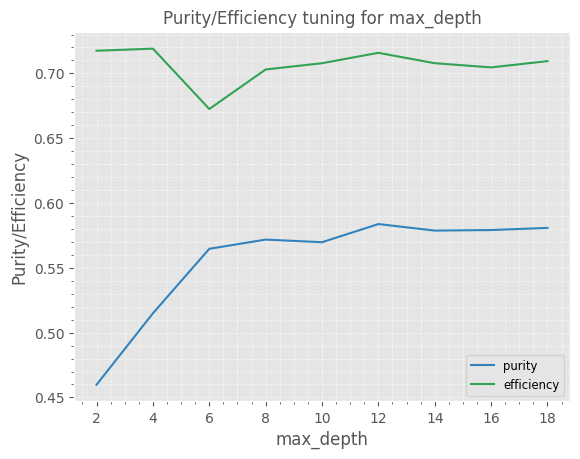

In [19]:
rf_hyper_param_tuning = {
    "max_depth": np.arange(2, 20, 2),
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True, verbose=True, binary_classification=False, consider_dropped_rows=False);

TUNING RANDOM FOREST HYPERPARAMETERS
--------------------------------
Testing n_estimators = 20...
Purity: 0.572, Efficiency: 0.660
--------------------------------
Testing n_estimators = 40...
Purity: 0.579, Efficiency: 0.679
--------------------------------
Testing n_estimators = 60...
Purity: 0.583, Efficiency: 0.701
--------------------------------
Testing n_estimators = 80...
Purity: 0.585, Efficiency: 0.698
--------------------------------
Testing n_estimators = 100...
Purity: 0.585, Efficiency: 0.697
--------------------------------
Testing n_estimators = 120...
Purity: 0.583, Efficiency: 0.698
--------------------------------
Testing n_estimators = 140...
Purity: 0.580, Efficiency: 0.697
--------------------------------
Testing n_estimators = 160...
Purity: 0.581, Efficiency: 0.697
--------------------------------
Testing n_estimators = 180...
Purity: 0.581, Efficiency: 0.700
--------------------------------
Testing n_estimators = 200...
Purity: 0.585, Efficiency: 0.701


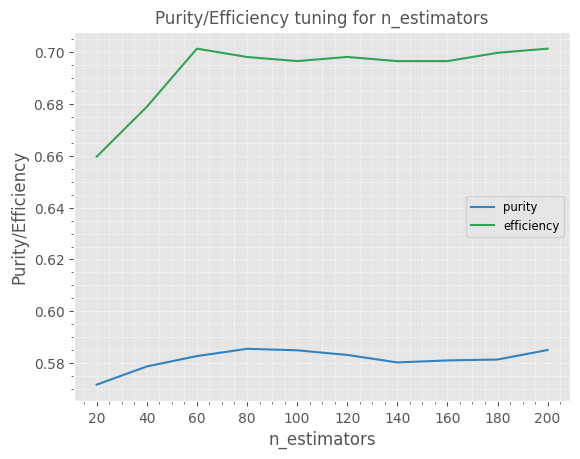

In [22]:
rf_hyper_param_tuning = {
    "n_estimators": np.arange(20, 220, 20),
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True, verbose=True, binary_classification=False, consider_dropped_rows=False);

In [ ]:
rf_hyper_param_tuning = {
    "min_samples_leaf": np.arange(1, 10, 1),
    "min_samples_split": np.arange(2, 10, 1)
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True);

# Understanding observables
Investigating the distributions of the observables and how the model is actually using them.

In [ ]:
# if not run already:
# data = extract_observables(mc, size=10000, start=0, beam_selection_mask=combined_mask, verbose=True)

In [120]:
df = pd.DataFrame(data)
df = clean_df(df, verbose=True)
df.drop(drop_cols, axis=1, inplace=True)
df.head()

Removed 1149 rows with missing entries. 


track_dEdX_mean  track_dEdX_median  track_dQdX_mean  \
0         2.558227           1.987254        71.891900   
1         2.185762           2.032390        65.696295   
2         2.697233           1.803803        70.462522   
3        46.238247           6.665603       246.978881   
4         0.957016           0.802299        27.266159   

   track_chi2/ndof_proton  track_chi2/ndof_muon  track_length  track_score  \
0              189.432676             14.285214      7.555305     0.089236   
1              215.380424             16.334994      7.812130     0.494838   
2              166.324808             14.788307     94.991625     0.875237   
3                1.984713             36.443756     23.881886     0.948290   
4              285.341374             30.075351      8.760562     0.002080   

          particle  track_vertex_michel  track_vertex_nhits  \
0         $\gamma$             6.598455                  20   
1  $\pi^{\pm}$:2nd             5.771489                  44   
2  $\pi^{\pm}$:2nd             4.309568                   9   
3              $p$             0.000004                   2   
4         $\gamma$             5.272155                  13   

   track_start_pos_x  track_start_pos_y  track_start_pos_z  track_end_pos_x  \
0         -70.826752         401.723602          94.095642       -75.680908   
1         -46.822456         410.084839          70.002876       -49.824867   
2         -44.871201         395.932922         140.981216      -104.971466   
3         -43.548687         394.825745         140.071350       -50.745937   
4         -95.880539         365.782501         208.046509       -93.991821   

   track_end_pos_y  track_end_pos_z  hit_density  angle_to_beam  
0       399.130554        99.272118     4.367792     -42.723208  
1       404.115784        74.050751     1.024048     -37.166300  
2       361.389008       205.434784     1.484341     -88.575353  
3       386.267365       161.125290     2.009892    -113.253265  
4       357.551147       210.375671     1.483923     -50.220107

In [121]:
x_train, x_test, y_train, y_test = split_data(df, test_size=0.2, verbose=True)

model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)  # using the default random forest as our benchmark
model.fit(x_train, y_train)
y_pred = model.predict(x_test).tolist()
y_test = y_test.tolist()

df_before_classification = x_test.copy()
df_before_classification["particle"] = y_test

mask = np.array(y_pred) == "$\\pi^{\\pm}$"
df_after_classification = df_before_classification.iloc[mask]

Training set size: 6623 tracks.
Testing set size: 1656 tracks.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## 1D distributions

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
                 Metric  Value
0            Pion Count    316
1  Total Test Particles   1656
2              Accuracy  0.731
3            pi± Purity  0.625
4        pi± Efficiency  0.728
5   Purity x Efficiency  0.455


RandomForestClassifier(random_state=42)

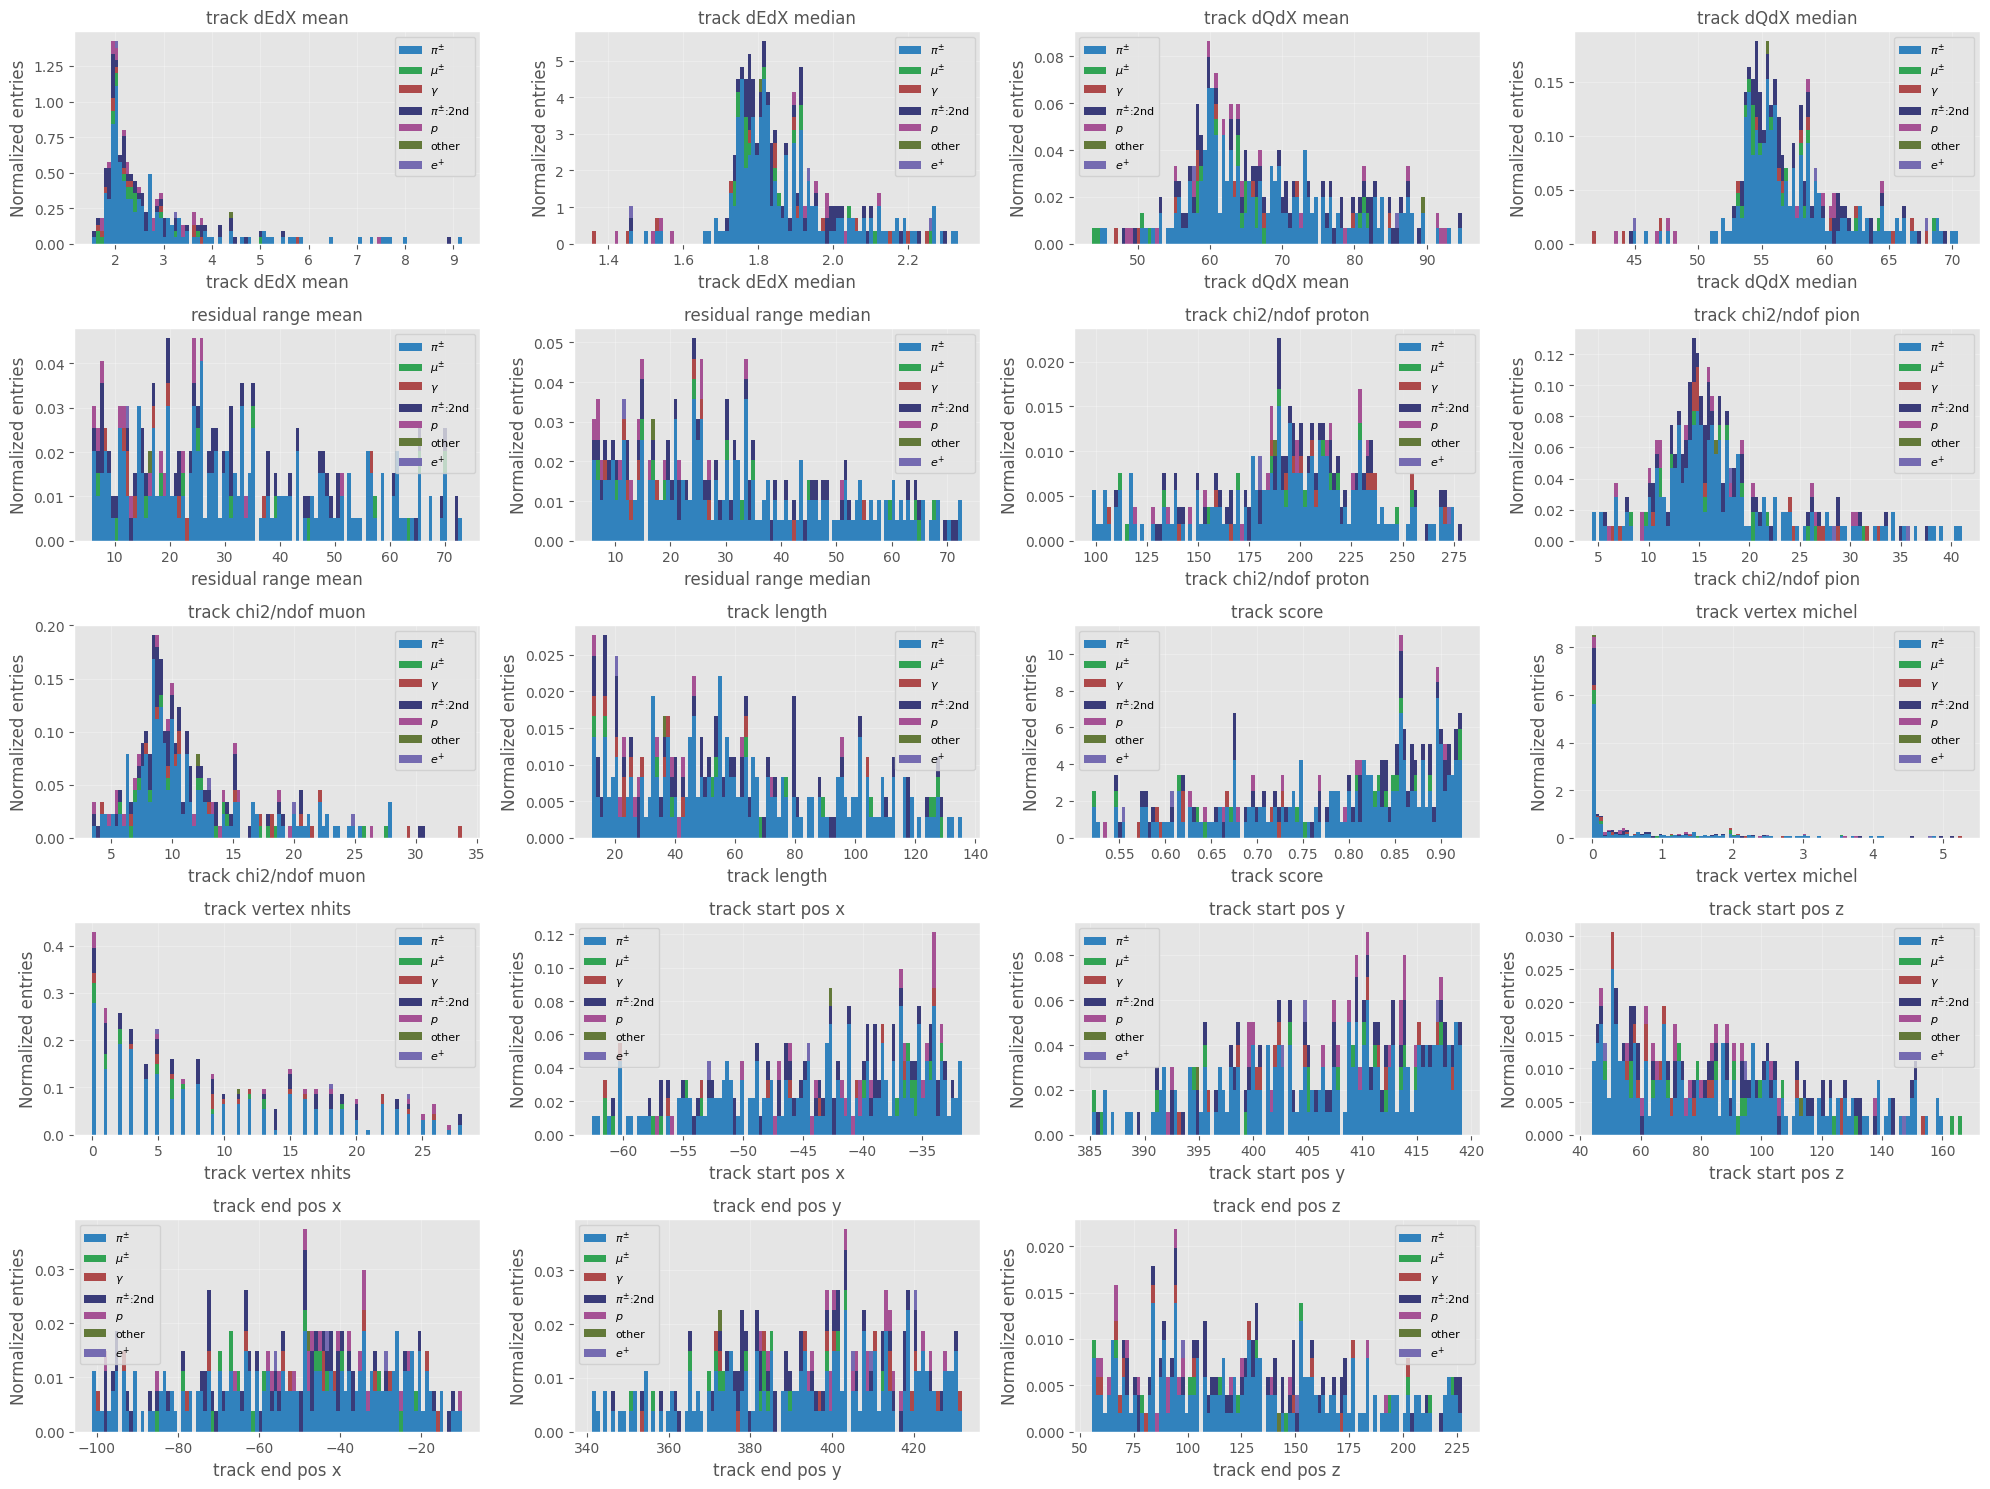

In [198]:
master_pion_selection(data=data, plot_obs_1d=True, verbose=True)

## 2D correlation plots

pdf /home/pemb6649/pi0-analysis/analysis/summer-placement/correlation_matrix.pdf has been opened


/home/pemb6649//pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has already been opened
  warnings.warn("pdf has already been opened")


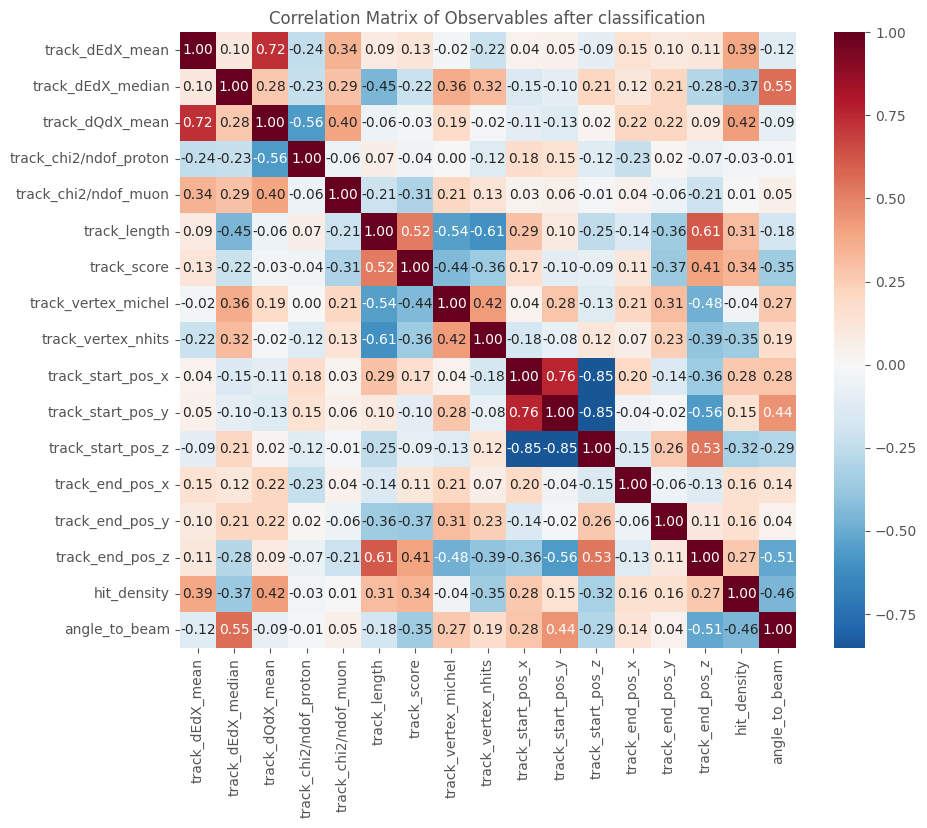

In [153]:
book = Plots.PlotBook("/home/pemb6649/pi0-analysis/analysis/summer-placement/correlation_matrix", True)
book.open()
plot_correlation_matrix(df_after_classification, title="Correlation Matrix of Observables after classification", size=(10, 8))
book.Save()


In [130]:
obs_to_plot = [col for col in df.columns if col != "particle"]
obs_to_plot

['track_dEdX_mean',
 'track_dEdX_median',
 'track_dQdX_mean',
 'track_chi2/ndof_proton',
 'track_chi2/ndof_muon',
 'track_length',
 'track_score',
 'track_vertex_michel',
 'track_vertex_nhits',
 'track_start_pos_x',
 'track_start_pos_y',
 'track_start_pos_z',
 'track_end_pos_x',
 'track_end_pos_y',
 'track_end_pos_z',
 'hit_density',
 'angle_to_beam']

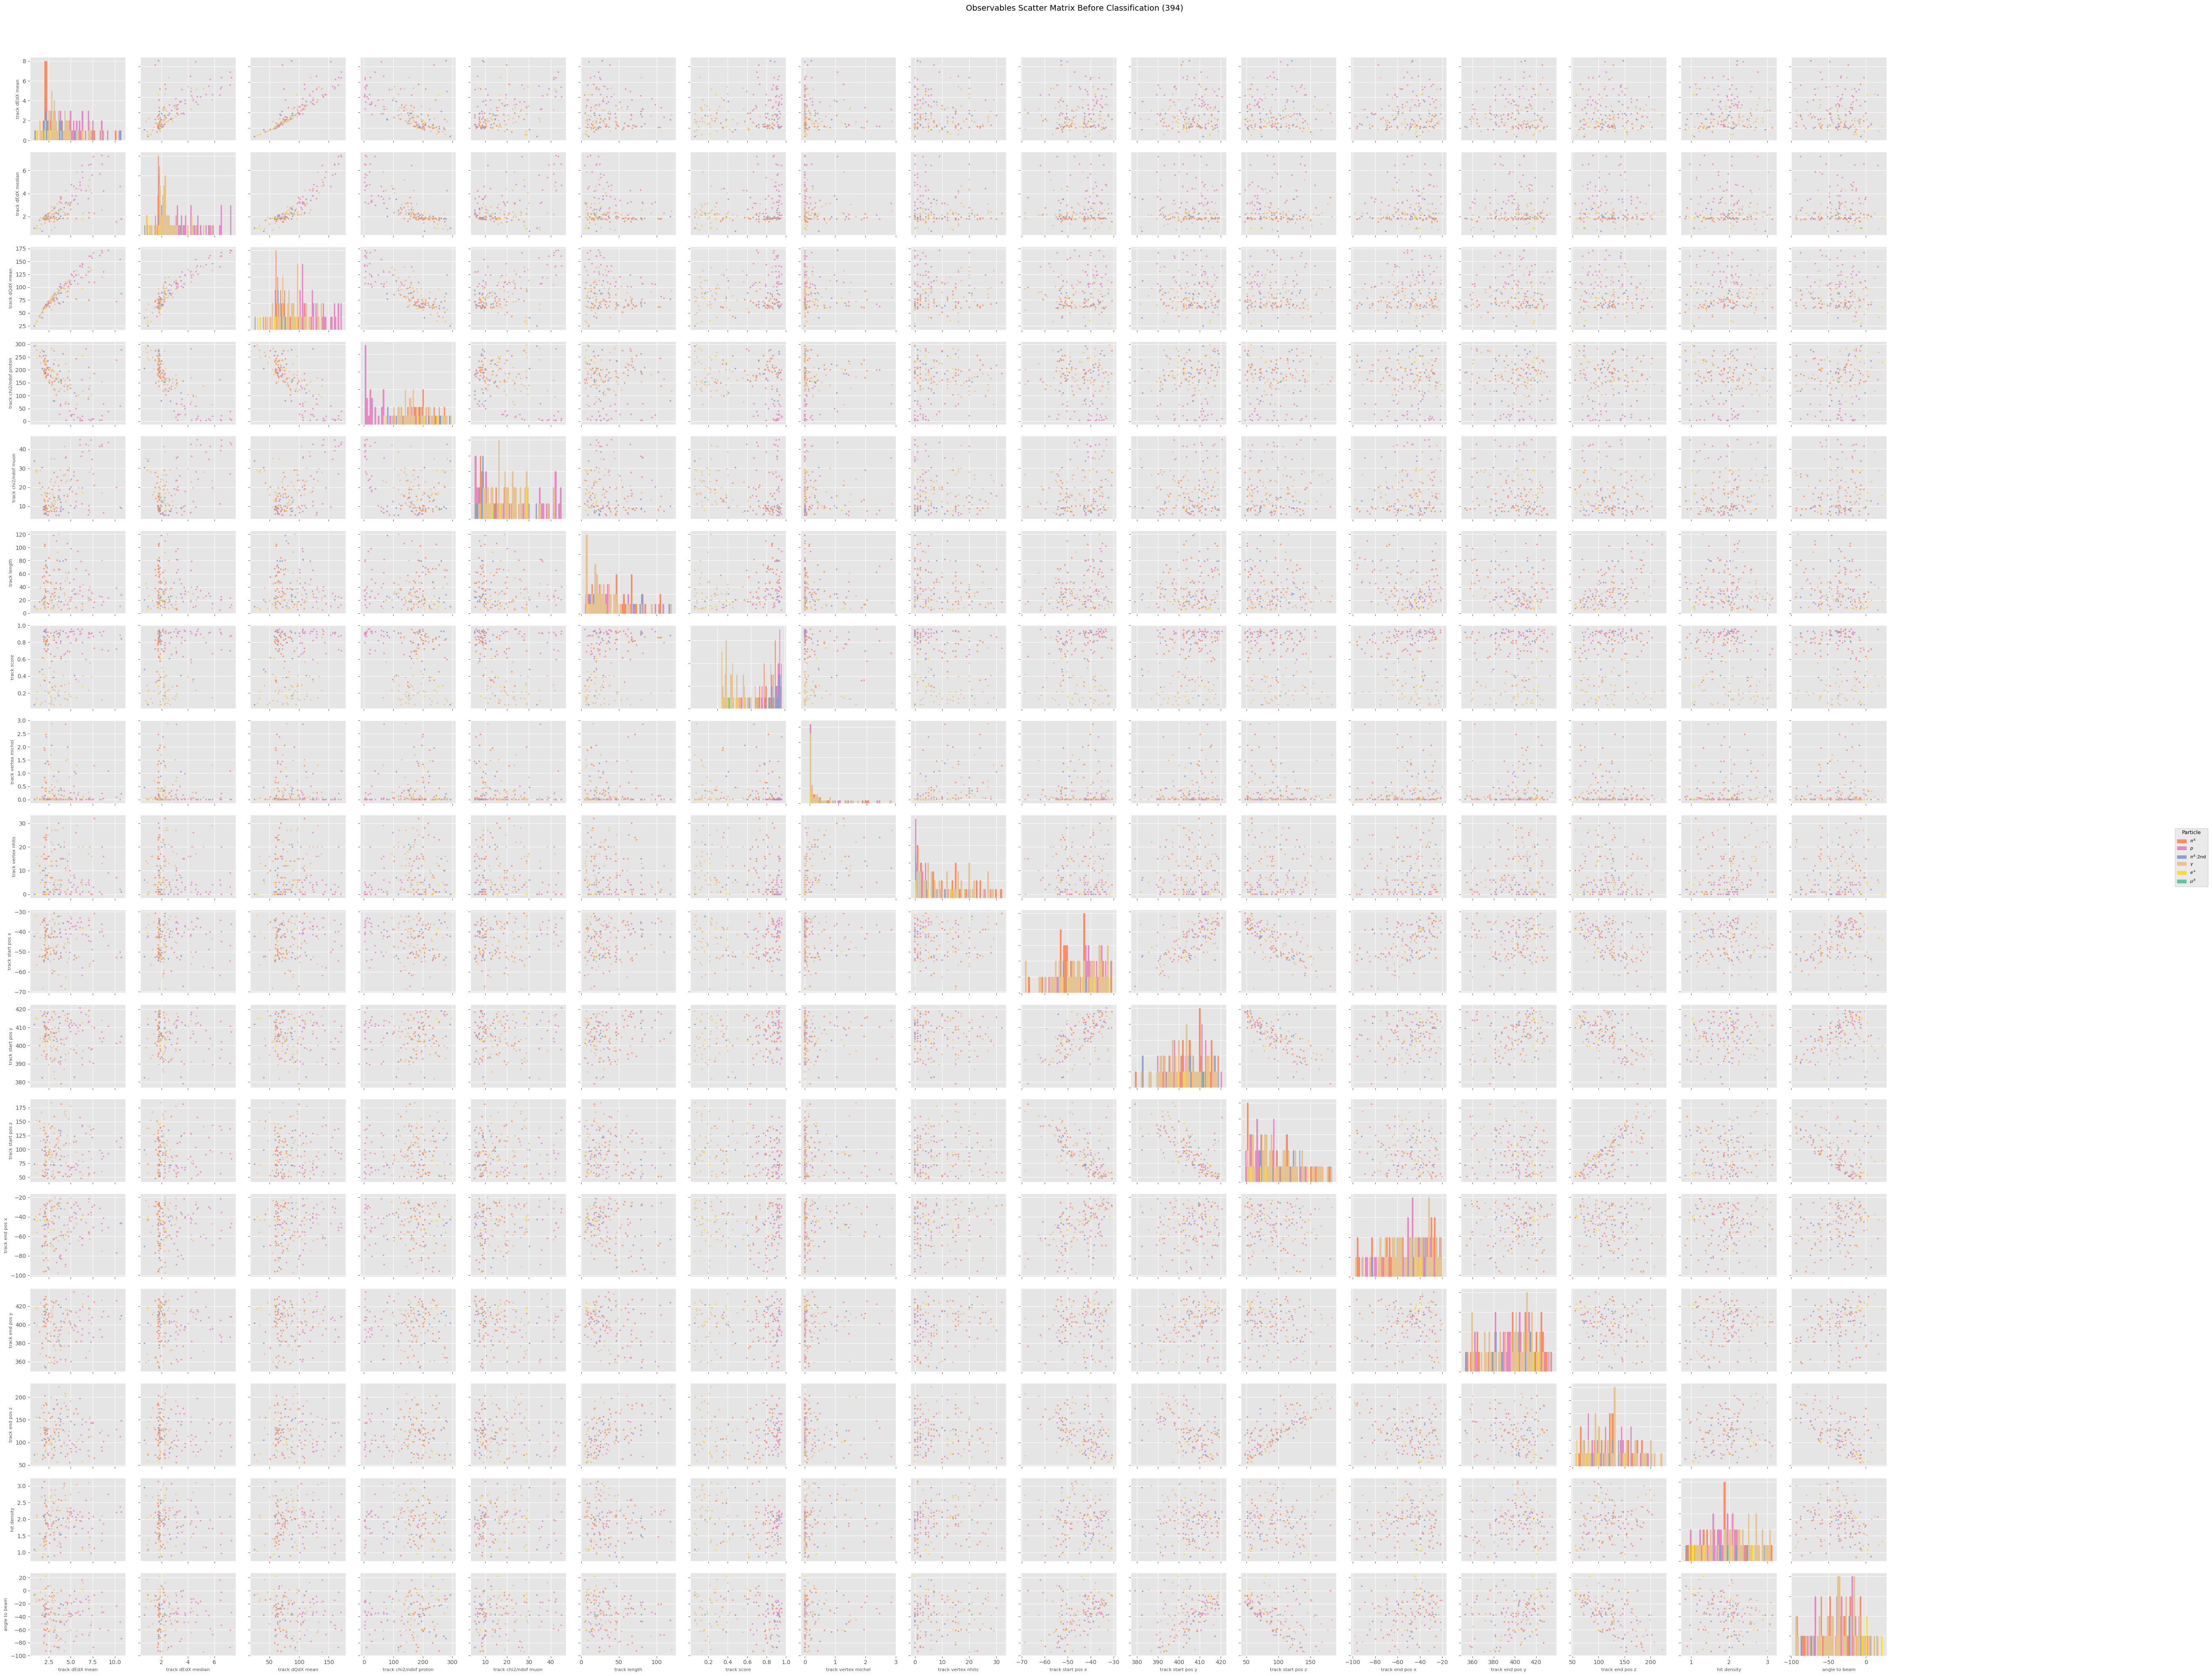

ValueError: No figure None

In [154]:
# first plot the scatter matrix for all observables
plot_scatter_matrix(df_before_classification, obs_to_plot, title=f"Observables Scatter Matrix Before Classification ({len(df_after_classification)})", size=(50, 40), save=False)
#plot_scatter_matrix(df_after_classification, obs_to_plot, title=f"Observables Scatter Matrix After Classification ({len(df_after_classification)})", size=(50, 40), save=False)
book.Save()

In [152]:
book.Save()

ValueError: No figure None

Plot saved to /home/pemb6649/pi0-analysis/analysis/summer-placement/observables-visualisation/scatter_matrix.png


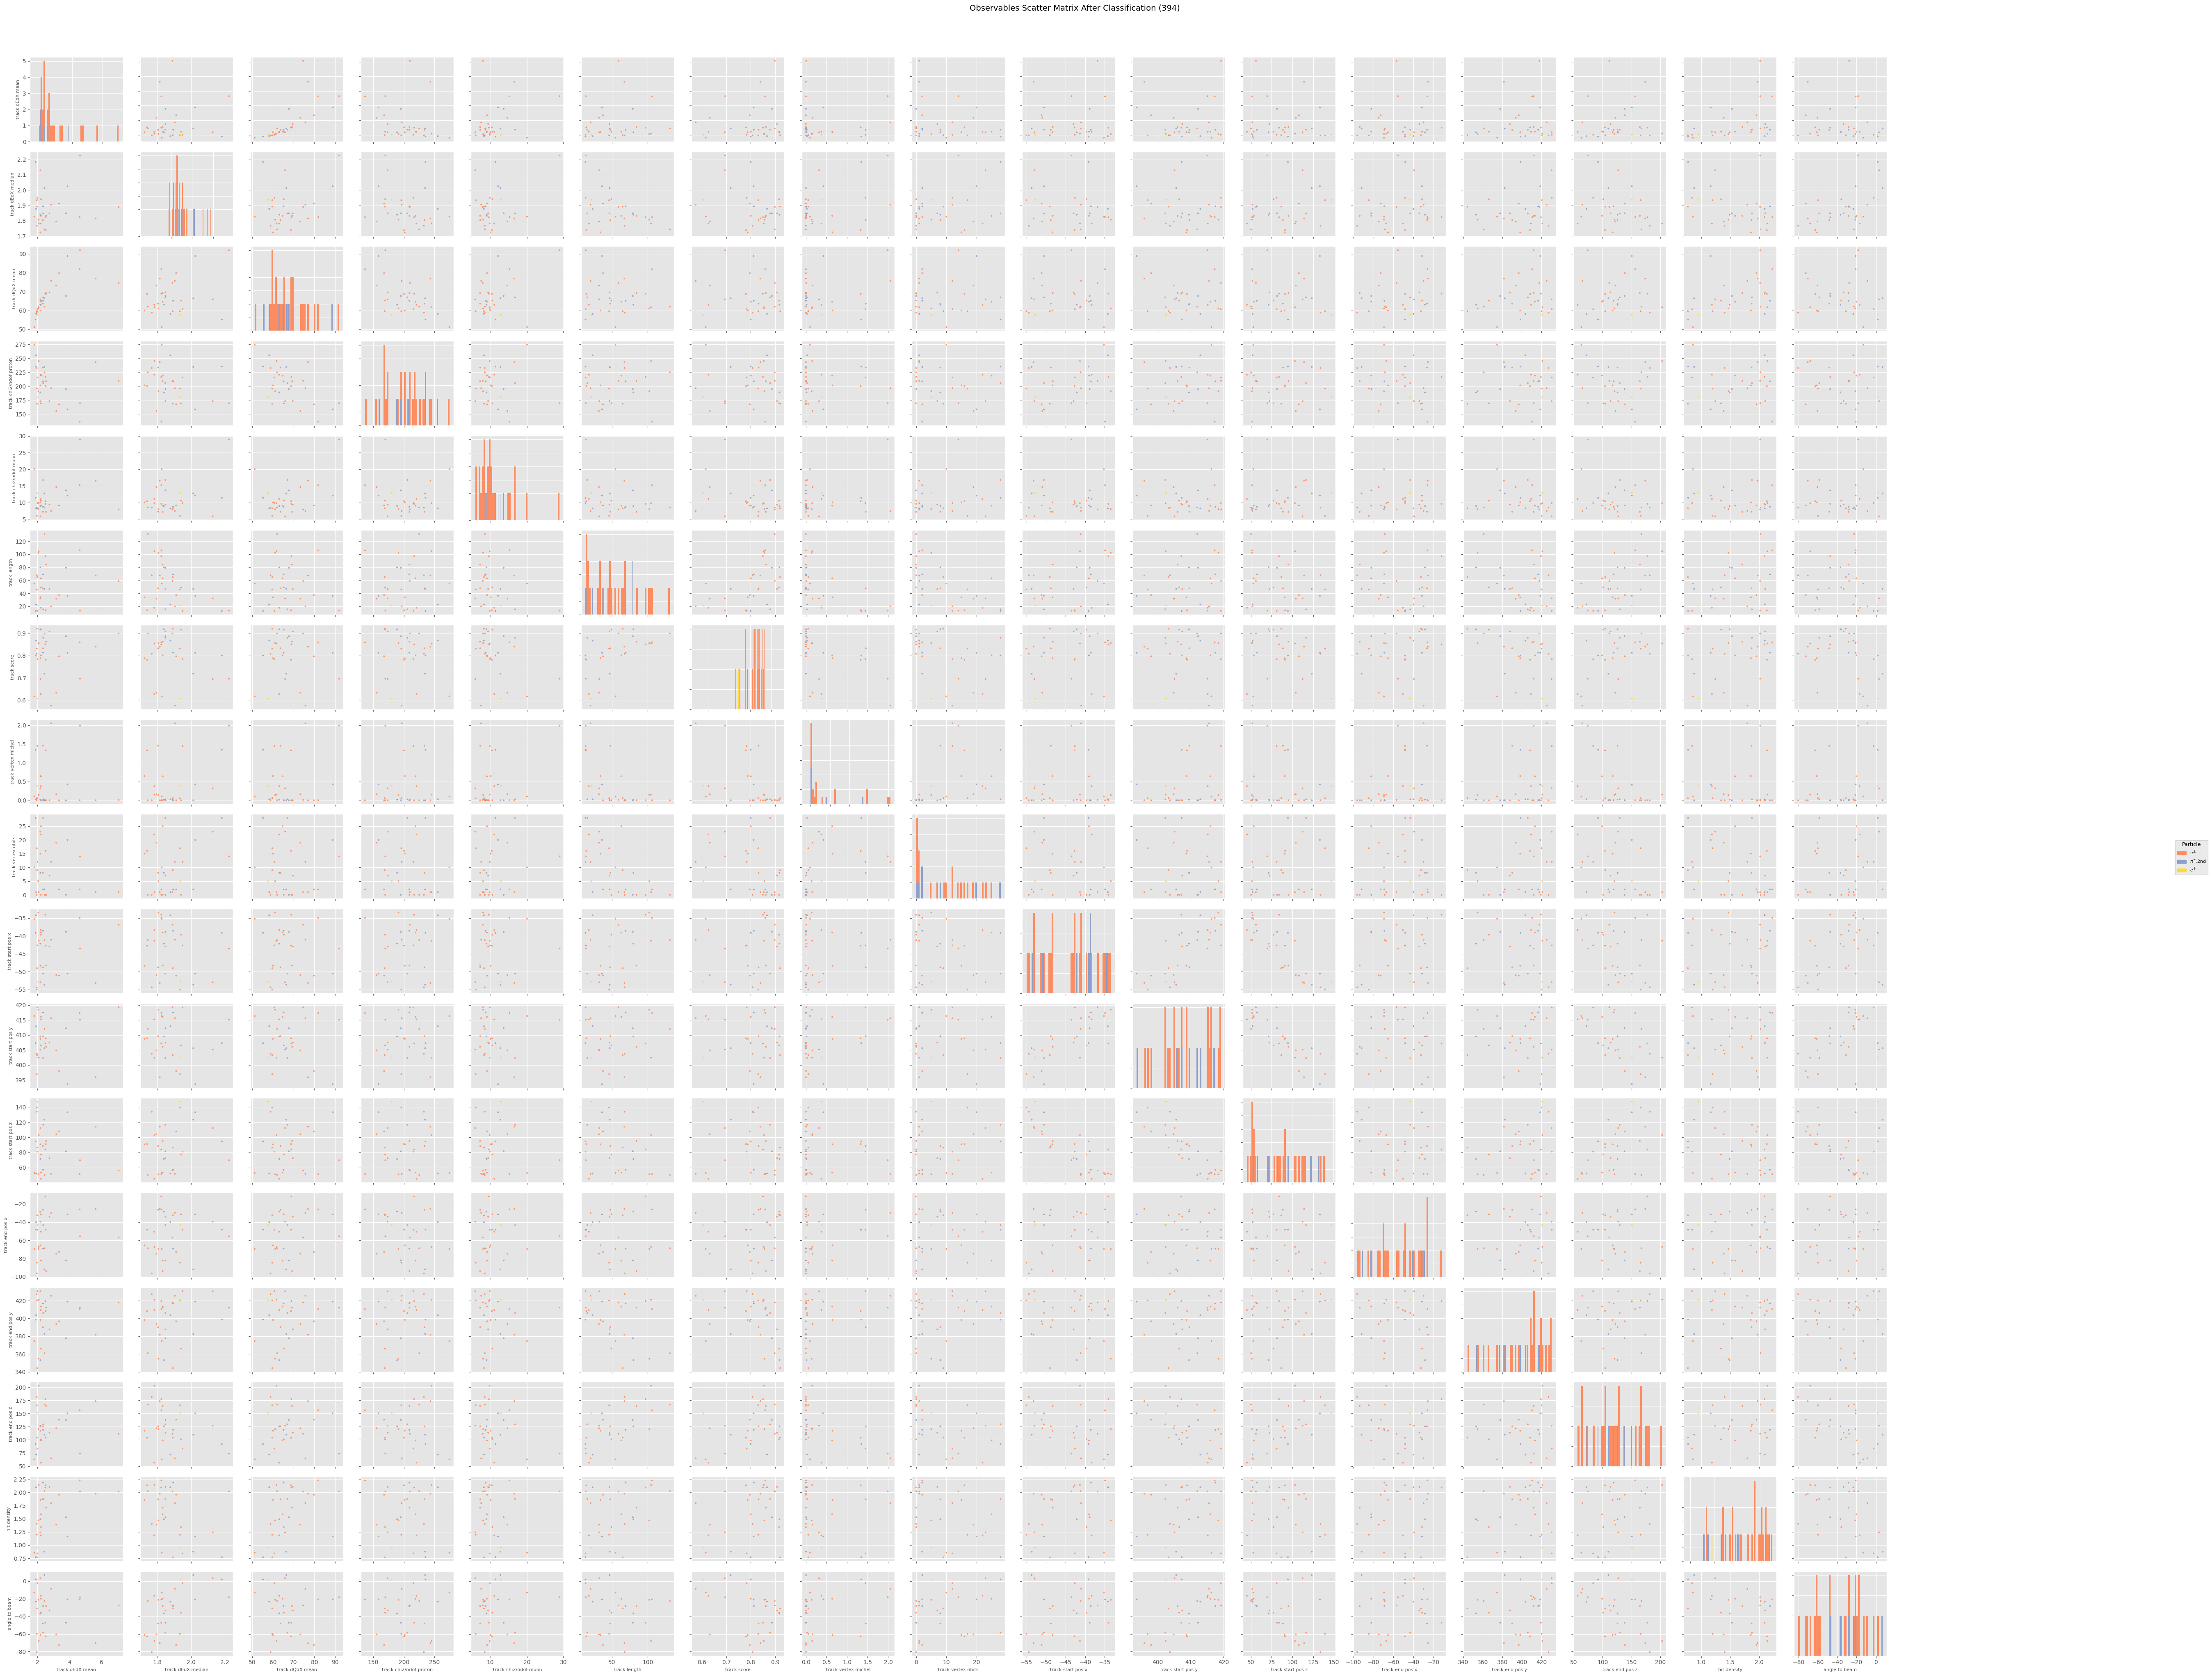

In [131]:
plot_scatter_matrix(df_after_classification, obs_to_plot, title=f"Observables Scatter Matrix After Classification ({len(df_after_classification)})", size=(50, 40), save=True)

## Test model again

In [143]:
# let's do a quick test after removing the correlated observables
drop_cols = ["residual_range_mean", "residual_range_median", "track_chi2/ndof_pion", "track_dQdX_median"]

RF = RandomForestClassifier(n_estimators=100, random_state=42, criterion="gini");
RF, pion_purity, pion_efficiency = master_pion_selection(data=data, drop_cols=drop_cols, model=RF, verbose=True, plot_importances=False, plot_cm=False, binary_classification=False, consider_dropped_rows=False)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
316 particles were classified as pions (out of the total 1656 particles in the test set).
accuracy: 0.745
pi± purity: 0.623
pi± efficiency: 0.753
Purity x Efficiency: 0.469


# New observables
Now we understand the model and observables a bit better, let's explore some new observables.

In [132]:
tags = GenerateTrueParticleTagsPiPlus(mc)
primary_end_pos = []
secondary_start_pos = []

for event in range(10000):
    if combined_mask[event] is False:
        continue
    for track in range(len(mc.recoParticles.track_chi2_proton[event])):
        if find_particle_from_tags(tags, event, track) == "$\pi^{\pm}$":
            primary_end_pos.append(mc.recoParticles.track_end_pos[event][track])
        elif find_particle_from_tags(tags, event, track) == "$\pi^{\pm}$:2nd":
            secondary_start_pos.append(mc.recoParticles.track_start_pos[event][track])

primary_end_pos = np.array(primary_end_pos)
secondary_start_pos = np.array(secondary_start_pos)
primary_end_pos.shape, secondary_start_pos.shape

((1703,), (935,))

In [ ]:
def find_distance(pos_1, pos_2):
    """
    Finds the position between two 3D position vectors.
    """
    return np.sqrt((pos_1["x"] - pos_2["x"])**2 + (pos_1["y"] - pos_2["y"])**2 + (pos_1["z"] - pos_2["z"])**2)

distance = find_distance(primary_end_pos[0], secondary_start_pos[0])
distance

52.58686554578913

In [ ]:
all_distances = []
for i in range(len(secondary_start_pos)):
    distances = []  # contains the distances from a given secondary pion start position to all primary pion end positions
    for j in range(len(primary_end_pos)):
        distance = find_distance(primary_end_pos[j], secondary_start_pos[i])
        distances.append(distance)
    distances = np.array(distances)
    distances.sort()
    all_distances.append(distances)

In [134]:
all_distances[1]

array([   4.50705172,    6.04169952,    6.38606702, ..., 2038.56733949,
       2038.56733949, 2038.56733949])